### PyTorch Computer vision

*  `torchvision` - base domain library for pytorch computer vision
*  `torchvision.datasets` - get datasets and data loading methods
*  `torchvision.models` - get pretrained models
*  `torchvision.transforms` - methods for manipulating vision data
*  `torch.utils.data.Dataset` Base dataset class for PyTorch
*  `torch.utils.data.DataLoader` - created python iterable over a dataset

### Computer Vision Libraries in Pytorch

In [28]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

#Import matplotlib
import matplotlib.pyplot as plt

* `ToTensor()` converts a `PIL Image` or `numpy.ndarray` to tensor.

In [29]:
# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


### Dataset

Load Fashion MNIST dataset from `torchvision.datasets`.

In [30]:
train_data = datasets.FashionMNIST(
    root = 'data', # where to download the data
    train = True, # Training data
    download = True, # Do we want to download?
    transform = ToTensor(), # Apply transform to train data
    target_transform = None  # Label transform
)

test_data = datasets.FashionMNIST(
    root = 'data', # where to download the data
    train = False, # Training data
    download = True, # Do we want to download?
    transform = ToTensor(), # Apply transform to test data
    target_transform = None  # Label transform
)

In [31]:
len(train_data), len(test_data)

(60000, 10000)

In [32]:
image, label = train_data[0]

In [33]:
image.shape

torch.Size([1, 28, 28])

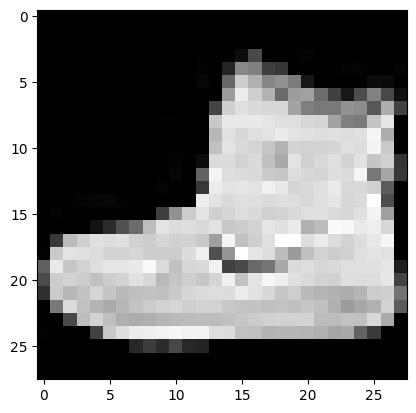

In [34]:
plt.imshow(image.reshape(28, 28), cmap = 'gray')

In [35]:
label

9

In [36]:
class_names = train_data.classes
class_names[9]

'Ankle boot'

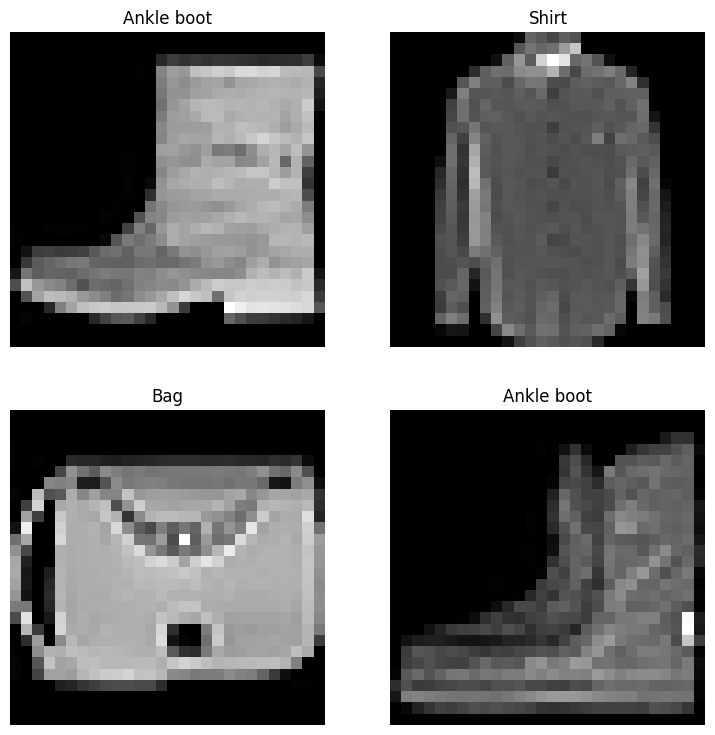

In [37]:
# Plot images
torch.manual_seed(42)

fig = plt.figure(figsize = (9, 9))
rows, cols = 2, 2
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap = 'gray')
  plt.title(class_names[label])
  plt.axis(False)

### DataLoader

In [38]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data, 
                              batch_size = 32,
                              shuffle = True)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = 32,
    shuffle = False
)

In [39]:
train_dataloader

In [40]:
test_dataloader

In [41]:
print(f"DataLoaders : {train_dataloader, test_dataloader}")
print(f"Length : {len(train_dataloader)} batches of 32")

DataLoaders : (<torch.utils.data.dataloader.DataLoader object at 0x7f16bc902890>, <torch.utils.data.dataloader.DataLoader object at 0x7f16bf2cf970>)
Length : 1875 batches of 32


In [42]:
# Check train_dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image Shape : torch.Size([1, 28, 28])


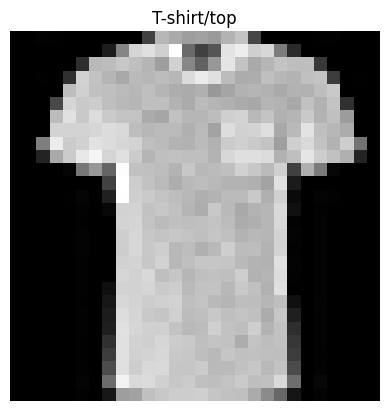

In [43]:
# Visualiz a batch
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size = [1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap = 'gray')
plt.title(class_names[label])
plt.axis(False)
print(f"Image Shape : {img.shape}")

### Create a Baseline Model

A baseline model is a simple model we build initially and will try to improve upon with subsequent experiments.

In [51]:
# Create a Baseline model
from torch import nn

class FashionMNISTModelV0(nn.Module):

  # Constructor
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.Linear(in_features=hidden_units, out_features = output_shape)
    )

    # Activation
  def forward(self, x):
      return self.layer_stack(x)

In [52]:
torch.manual_seed(42)

# Setup model
model_0 = FashionMNISTModelV0(
    input_shape = 784,
    hidden_units = 10,
    output_shape = 10
).to("cpu")

In [53]:
dummy_x = torch.rand([1, 784])
dummy_y = model_0(dummy_x)
dummy_y

### Setting up the training

Setting up loss, optimizer and evaluation metrics

In [56]:
import requests
from pathlib import Path

# Download helper functions from LearnPyTorch repo
if Path("helper_functions.py").is_file():
  print("Helper function exists already")
else:
  print("Downloading helper_functions.py......")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [58]:
# Import accuracy metrics from helper_functions
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [59]:
from timeit import default_timer as timer

def print_train_time(start:float, end:float):
  total_time = end - start
  print(f"Train time is {total_time} seconds")

### Training

In [62]:
from tqdm.auto import tqdm

In [81]:
import time

# Set the seed and start the timer
torch.manual_seed(42)
start = time.time()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
           
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
end = time.time()
print(f"Total time : {end-start} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.42655 | Test loss: 0.45735, Test acc: 84.01%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.42340 | Test loss: 0.45961, Test acc: 84.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.41963 | Test loss: 0.46264, Test acc: 83.99%

Total time : 43.20147895812988 seconds


### Evaluate the model

In [85]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """ Returns a dictionary containing the results of model predicting on data_loader"""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y,
                         y_pred = y_pred.argmax(dim = 1))
    
    loss /= len(data_loader)
    acc /= len(data_loader)
  
  return{"model_name": model.__class__.__name__,
         "model_loss" : loss.item(),
         "model_acc":acc}

In [86]:
model_0_results = eval_model(model = model_0,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [87]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.46264058351516724,
 'model_acc': 83.98562300319489}

### Setup device agnostic code